# Second Approch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from sympy import Symbol
import copy as cp
import seaborn as sns
from scipy.linalg import cholesky
from math import sqrt
from numpy import shape

In this approch, the objectif is to use the modeling equation (1) of $H$, the water level of the watercourse, in order to minimize the overflow height, $S$, that is related to the physical variables and the height of the dike by the equation (2).

$H = {\left(\frac{Q}{K_s \sqrt(\frac{Z_m - Z_v}{L}) B}\right)}^{\frac{3}{5}} \ (1)$

$S = Z_c - Z_d = Zv + H - \mathcal{H}_d - Z_b \ (2) $

By the formulation of the problem, the major sources of uncertainty are considered to be the variables $Q$, $Z_m$, $Z_v$ and $K_s$. In this sense these variables are considered to be random variables with the following distributions :

$Q \sim Gumbel(1013, 558)$

$Z_m \sim Triangular(55, halfrange = 1)$

$Z_v \sim Triangular(50, halfrange = 1)$

$K_s \sim \mathcal{N}(30, 7.5)$

The other variables, $B$, $L$ and $Z_b$, are considered to be deterministics with values 300, 5000 and 55,5 respectively.

For the development that follows, it will be considered the 3 different scenarios:

1) Random variables without correlation

2) Correlation $K_s$-$Z_v$ of -0.6 and $Z_v$-$Z_m$ of 0.6

3) Correlation $K_s$-$Z_v$ of -0.3, $Z_v$-$Z_m$ of 0.66 and $K_s$-$Z_m$ of -0.5

-----

1) Generating realisations of the random variables and defining constants for the 3 scenarios

In [2]:
def PosNormal(mean, sigma):
    x = np.random.normal(mean,sigma)
    return(x if x>=0 else PosNormal(mean,sigma))

def PosGumbel(mode, scale):
    x = np.random.gumbel(mode,scale)
    return(x if x>=0 else PosGumbel(mode,scale))

#n_sub_samples=len(Height)
def generate_sample(n=1000):
    sample=[]
    Q_a=np.array([PosGumbel(1013,558) for i in range(n)])
    k_sa=np.array([PosNormal(30,7.5) for i in range(n)])
    Z_va=np.array([np.random.triangular(49,50,51) for i in range(n)])
    Z_ma=np.array([np.random.triangular(54,55,56) for i in range(n)])
    sample=np.array([Q_a,k_sa,Z_va,Z_ma])
    return sample

In [3]:
n_sample=1000000
sample=generate_sample(n_sample)

#first scenario
q_realisations = sample[0]
ks_realisations = sample[1]
zv_realisations = sample[2]
zm_realisations = sample[3]
 
#second scenario
cov_matrix2 = np.array([
        [  1, -0.6, 0],
        [ -0.6,  1,  0.6],
        [ 0,  0.6,  1]
    ])

c2 = cholesky(cov_matrix2)

realisations_2 =np.zeros([q_realisations.shape[0],4])
for i in range(q_realisations.shape[0]):
    uncorrelated_var_i = [ks_realisations[i],zv_realisations[i],zm_realisations[i]]
    correlated_var_i = np.dot(c2,uncorrelated_var_i)
    realisations_2[i][:]=[q_realisations[i],correlated_var_i[0],correlated_var_i[1],correlated_var_i[2]]

#third scenario
cov_matrix3 = np.array([
        [  1, -0.3, -0.5],
        [ -0.3,  1,  0.66],
        [ -0.5,  0.66,  1]
    ])

c3 = cholesky(cov_matrix3)

realisations_3 = np.zeros([q_realisations.shape[0],4])
for i in range(q_realisations.shape[0]):
    uncorrelated_var_i = [ks_realisations[i],zv_realisations[i],zm_realisations[i]]
    correlated_var_i = np.dot(c3,uncorrelated_var_i)
    realisations_3[i][:]=[q_realisations[i],correlated_var_i[0],correlated_var_i[1],correlated_var_i[2]]


2) Histogram of the data generated for the first scenario

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose l

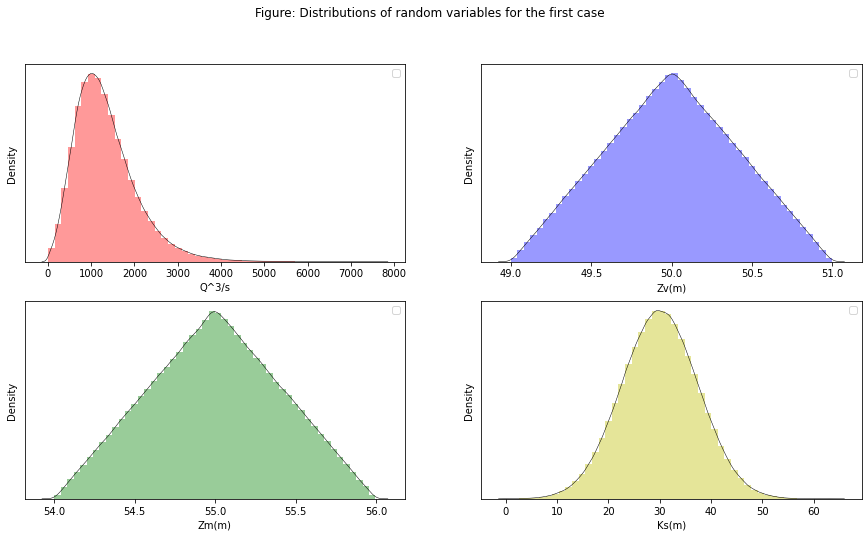

In [4]:
#first scenario

x=np.linspace(0.9,7.7,100)
fig, ax = plt.subplots(2,2,figsize=(15,8))

sns.distplot(q_realisations,ax=ax[0][0],color='r',kde_kws={"color": "k", "lw": 0.5})
ax[0][0].set_xlabel('Q^3/s')
ax[0][0].set_yticks([])
ax[0][0].legend()

sns.distplot(zv_realisations,ax=ax[0][1],color='b',kde_kws={"color": "k", "lw": 0.5})
ax[0][1].set_xlabel('Zv(m)')
ax[0][1].set_yticks([])
ax[0][1].legend()

sns.distplot(zm_realisations,ax=ax[1][0],color= 'g',kde_kws={"color": "k", "lw": 0.5})
ax[1][0].set_xlabel('Zm(m)')
ax[1][0].set_yticks([])
ax[1][0].legend()

sns.distplot(ks_realisations,ax=ax[1][1],color='y',kde_kws={"color": "k", "lw": 0.5})
ax[1][1].set_xlabel('Ks(m)')
ax[1][1].set_yticks([])
ax[1][1].legend()

fig.suptitle('Figure: Distributions of random variables for the first case') 

plt.show()

3) Histogram of the data generated for the second scenario

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose l

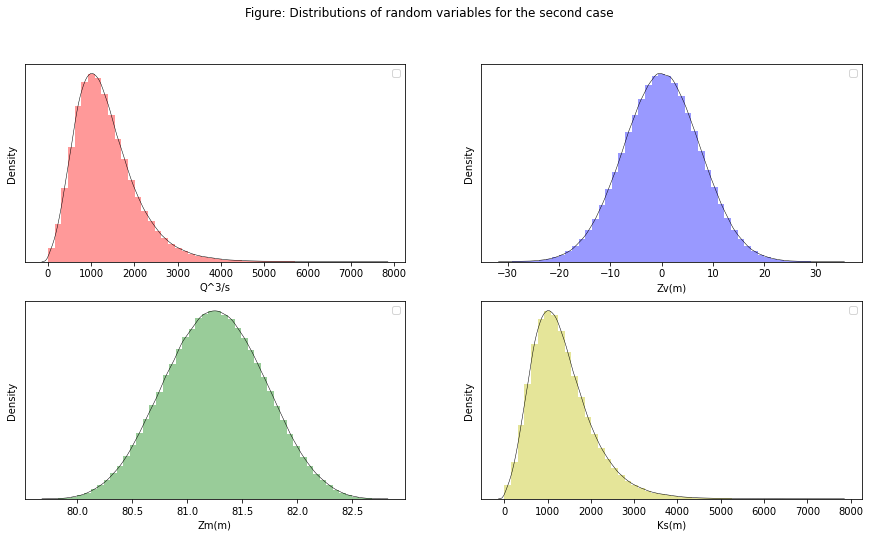

In [5]:
#second scenario

fig, ax = plt.subplots(2,2,figsize=(15,8))

sns.distplot(q_realisations,ax=ax[0][0],color='r',kde_kws={"color": "k", "lw": 0.5})
ax[0][0].set_xlabel('Q^3/s')
ax[0][0].set_yticks([])
ax[0][0].legend()

sns.distplot(realisations_2[:,1],ax=ax[0][1],color='b',kde_kws={"color": "k", "lw": 0.5})
ax[0][1].set_xlabel('Zv(m)')
ax[0][1].set_yticks([])
ax[0][1].legend()

sns.distplot(realisations_2[:,2],ax=ax[1][0],color= 'g',kde_kws={"color": "k", "lw": 0.5})
ax[1][0].set_xlabel('Zm(m)')
ax[1][0].set_yticks([])
ax[1][0].legend()

sns.distplot(realisations_2[:,0],ax=ax[1][1],color='y',kde_kws={"color": "k", "lw": 0.5})
ax[1][1].set_xlabel('Ks(m)')
ax[1][1].set_yticks([])
ax[1][1].legend()

fig.suptitle('Figure: Distributions of random variables for the second case') 

plt.show()

4) Histogram of the generated data for the third scenario

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose l

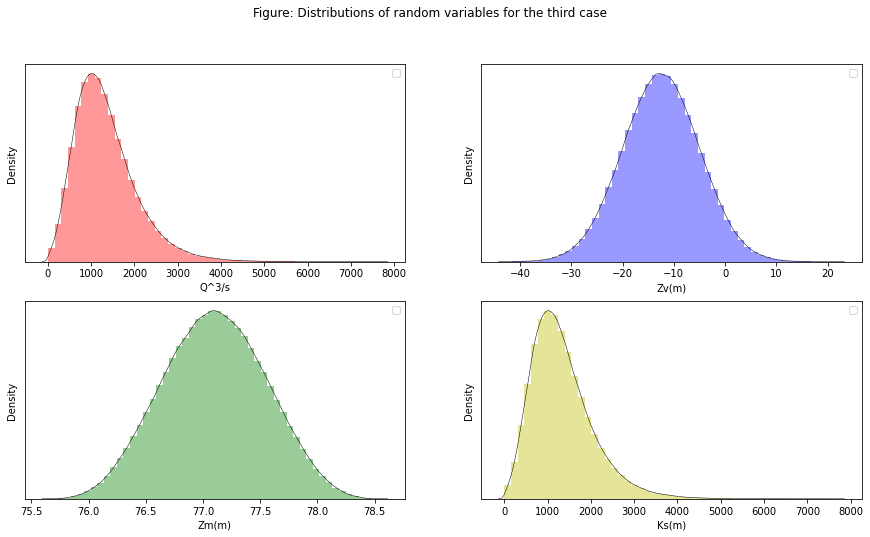

In [6]:
#third scenario

fig, ax = plt.subplots(2,2,figsize=(15,8))

sns.distplot(q_realisations,ax=ax[0][0],color='r',kde_kws={"color": "k", "lw": 0.5})
ax[0][0].set_xlabel('Q^3/s')
ax[0][0].set_yticks([])
ax[0][0].legend()

sns.distplot(realisations_3[:,1],ax=ax[0][1],color='b',kde_kws={"color": "k", "lw": 0.5})
ax[0][1].set_xlabel('Zv(m)')
ax[0][1].set_yticks([])
ax[0][1].legend()

sns.distplot(realisations_3[:,2],ax=ax[1][0],color= 'g',kde_kws={"color": "k", "lw": 0.5})
ax[1][0].set_xlabel('Zm(m)')
ax[1][0].set_yticks([])
ax[1][0].legend()

sns.distplot(realisations_3[:,0],ax=ax[1][1],color='y',kde_kws={"color": "k", "lw": 0.5})
ax[1][1].set_xlabel('Ks(m)')
ax[1][1].set_yticks([])
ax[1][1].legend()

fig.suptitle('Figure: Distributions of random variables for the third case') 

plt.show()

5) Generating the realisations of H and S in the diferent scenarios. The S is considered with $\mathcal{H}_d = 0$.

In [7]:
def generate_s_sample(sample:list,B=300,L=5000,Zb=55.5,hd=0):
    Q,Ks,Zv,Zm=sample[0],sample[1],sample[2],sample[3]
    strike_coef=np.power(np.multiply(Q,1/(B*np.multiply(Ks,np.sqrt((Zm-Zv)/L)))),3/5) 
    S=Zv+strike_coef+hd-Zb 
    return S, strike_coef

In [8]:
first_scenario=[q_realisations,ks_realisations,zv_realisations,zm_realisations]
second_scenario=[realisations_2[:,0],realisations_2[:,1],realisations_2[:,2],realisations_2[:,3]]
third_scenario=[realisations_3[:,0],realisations_3[:,1],realisations_3[:,2],realisations_3[:,3]]

alpha=0.995

first_scenario, H_1=generate_s_sample(first_scenario)
first_scenario=np.sort(first_scenario)
H_1=np.sort(H_1)
first_scenario=np.delete(first_scenario,np.isnan(first_scenario))
first_scenario=first_scenario[0:int(len(first_scenario)*alpha)]

second_scenario, H_2=generate_s_sample(second_scenario)
second_scenario=np.sort(second_scenario)
H_2=np.sort(H_2)
second_scenario=np.delete(second_scenario,np.isnan(second_scenario),axis=0)
second_scenario=second_scenario[0:int(len(second_scenario)*alpha)]

third_scenario, H_3=generate_s_sample(third_scenario)
third_scenario=np.sort(third_scenario)
H_3=np.sort(H_3)
third_scenario=np.delete(third_scenario,np.isnan(third_scenario),axis=0)
third_scenario=third_scenario[0:int(len(second_scenario)*alpha)]

C:\Users\analu\AppData\Local\Temp\ipykernel_38780\2679847822.py:3: RuntimeWarning: invalid value encountered in sqrt
  strike_coef=np.power(np.multiply(Q,1/(B*np.multiply(Ks,np.sqrt((Zm-Zv)/L)))),3/5)


c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib

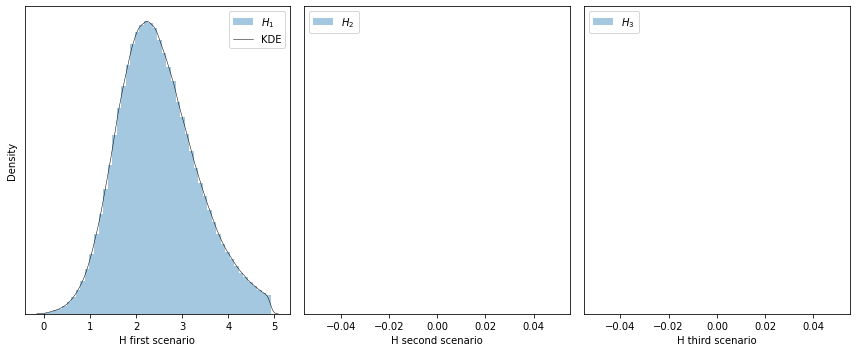

In [9]:
fig, ax = plt.subplots(1,3,figsize=(12,5))

sns.distplot(H_1[1:980000],ax=ax[0],label='$H_1$',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[0].set_yticks([])
ax[0].set_xlabel('H first scenario')
ax[0].legend()
sns.distplot(H_2[1:980000],ax=ax[1],label='$H_2$',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[1].set_yticks([])
ax[1].set_xlabel('H second scenario')
ax[1].legend()
sns.distplot(H_3[1:980000],ax=ax[2],label='$H_3$',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[2].set_yticks([])
ax[2].set_xlabel('H third scenario')
ax[2].legend()
plt.tight_layout()
# plt.savefig('Fig4.eps',format = 'eps')
plt.show()

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\

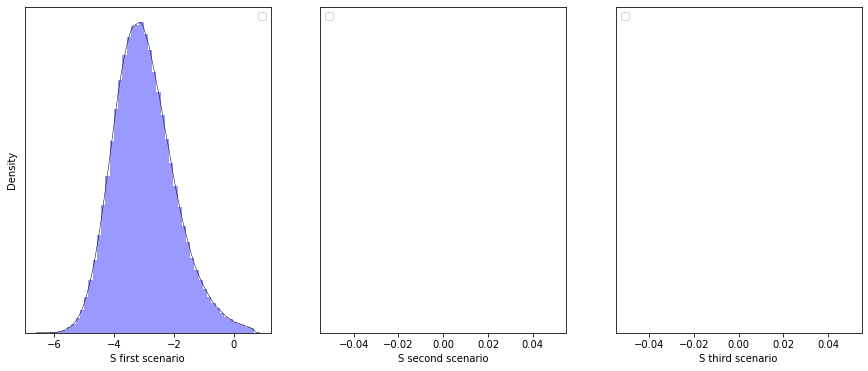

In [10]:
fig, ax = plt.subplots(1,3,figsize=(15,6))

sns.distplot(first_scenario,ax=ax[0],color='b',kde_kws={"color": "k", "lw": 0.5})
ax[0].set_xlabel('S first scenario')
ax[0].set_yticks([])
ax[0].legend()

sns.distplot(second_scenario,ax=ax[1],color='g',kde_kws={"color": "k", "lw": 0.5})
ax[1].set_xlabel('S second scenario')
ax[1].set_yticks([])
ax[1].legend()

sns.distplot(third_scenario,ax=ax[2],color='y',kde_kws={"color": "k", "lw": 0.5})
ax[2].set_xlabel('S third scenario')
ax[2].set_yticks([])
ax[2].legend()

plt.show()

6) Hypothesis test to determine a parametric distribution for S in the first scenario. This hypothesis test analyses if the parametric distribution represents the distribution of dataset. In this step we are able to determinate an $\mathcal{H}_d$ correspondant to the 95% quantile using the empirical distribution and the deduced parametric distribution. It's used the $\chi^2$ hypothesis test.

In [ ]:
emp_mean = np.mean(first_scenario)
emp_stand_dev = np.std(first_scenario)


#pvalue for the normal distribution using the chi2 test
n=100
df=n-2-1
hist_values = np.zeros(n)
for i in range(n):
    hist_values[i] = np.exp(np.log(11)(i/n)*2)-1
#print(hist_values)
expon_cste = scp.stats.expon.fit(first_scenario)
hist_exp_cdf = scp.stats.expon.cdf(hist_values,expon_cste[0],expon_cste[1])
hist = np.zeros(n)
Tx = 0
erro = 0
hist_exp = np.zeros(n)
for i in range(len(hist_values)-1):
    hist[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_exp[i]=(hist_exp_cdf[i+1]-hist_exp_cdf[i])*len(first_scenario)
    Tx += (hist[i]-hist_exp[i])**2/hist_exp[i]
    erro+=(hist[i]-hist_exp[i])**2
print(1-scp.stats.chi2.cdf(df,Tx))
print(erro)

#pvalue for the weibull distribution using the chi2 test
weibull_cste = scp.stats.weibull_min.fit(first_scenario)
hist_wei_cdf = scp.stats.weibull_min.cdf(hist_values,weibull_cste[0],weibull_cste[1],weibull_cste[2])
hist2 = np.zeros(n)
Tx2 = 0
erro2 = 0
hist_wei = np.zeros(n)
for i in range(len(hist_values)-1):
    hist2[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_wei[i]=(hist_wei_cdf[i+1]-hist_wei_cdf[i])*len(first_scenario)
    Tx2 += (hist2[i]-hist_wei[i])**2/hist_wei[i]
    erro2 += (hist2[i]-hist_wei[i])**2
print(1-scp.stats.chi2.cdf(df-1,Tx2))
print(erro2)

#pvalue for the gumbel distribution using the chi2 test
gumbell_cste = scp.stats.gumbel_r.fit(first_scenario)
hist_gum_cdf = scp.stats.gumbel_r.cdf(hist_values,gumbell_cste[0],gumbell_cste[1])
hist3 = np.zeros(n)
Tx3 = 0
erro3 = 0
hist_gum = np.zeros(n)
for i in range(len(hist_values)-1):
    hist3[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_gum[i]=(hist_gum_cdf[i+1]-hist_gum_cdf[i])*len(first_scenario)
    Tx3 += (hist3[i]-hist_gum[i])**2/hist_gum[i]
    erro3 += (hist3[i]-hist_gum[i])**2
print(1-scp.stats.chi2.cdf(df,Tx3))
print(erro3)

#plotting the histograms to undestand the comparison between the fitted distributions and the empirical one
x=np.linspace(0,10,100)
fig, ax = plt.subplots(1,3,figsize=(12,5))

sns.distplot(first_scenario,ax=ax[0],label='Exp',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[0].plot(x,scp.stats.expon.pdf(x,expon_cste[0],expon_cste[1]),\
         lw=2,label='Norm')
ax[0].set_yticks([])
ax[0].set_xlabel('Normal distribution')
ax[0].legend()
sns.distplot(first_scenario,ax=ax[1],label='Weibull',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[1].plot(x,scp.stats.weibull_min.pdf(x,weibull_cste[0],weibull_cste[1],weibull_cste[2]),\
         lw=2,label='Weibull')
ax[1].set_yticks([])
ax[1].set_xlabel('Weibull distribution')
ax[1].legend()
sns.distplot(first_scenario,ax=ax[2],label='Gumbell',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[2].plot(x,scp.stats.gumbel_r.pdf(x,gumbell_cste[0],gumbell_cste[1]),\
         lw=2,label='Gumbell')
ax[2].set_yticks([])
ax[2].set_xlabel('Normal distribution')
ax[2].legend()
plt.tight_layout()
# plt.savefig('Fig4.eps',format = 'eps')
plt.show()

6) Generating 10000 simulations and deducing the distribution of the chosen height of the dike $\mathcal{H_d}$.

In [ ]:
N_simulations = 1000
N_sample = 1000000

def multiple_simulations(N_sim, N_samples):
    S_1 = np.zeros(N_samples)
    H_1 = np.zeros(N_samples)
    h_d = np.zeros(N_sim)
    for i in range(N_sim):
        sample = generate_sample(N_samples)
        S_1, H_1 = generate_s_sample([sample[0],sample[1],sample[2],sample[3]])
        S_1 = np.sort(S_1)
        H_1 = np.sort(H_1)
        S_1 = S_1[S_1>0]
        h_d[i] = np.quantile(S_1,0.95)
    return h_d

h_d = multiple_simulations(N_simulations,N_sample)

plt.figure(figsize=(15,6))
sns.distplot(h_d,color='b',kde_kws={"color": "k", "lw": 0.5})
plt.set_xlabel('$\mathcal{H}_d$ distribution')
plt.set_yticks([])
plt.legend()